In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

# 1. Load dataset
df = pd.read_excel("dataset_labeled_wsn.xlsx")

# 2. Define X, y
X = df.drop(columns=["label"])
y = df["label"]

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. SMOTE balancing
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_scaled, y_train)

# 6. Load / Build final model
# Jika kamu punya file PKL:
import joblib
model_sim = joblib.load("rf_wsn_multiclass_best_pipeline.pkl")

# Kalau belum pakai file, kita definisikan model tunning final:
model_sim = RandomForestClassifier(
    n_estimators=279,
    max_depth=5,
    min_samples_leaf=2,
    min_samples_split=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

# Train model final
model_sim.fit(X_train_bal, y_train_bal)

# 7. Define label order (UNTUK PLOTTING)
label_order = sorted(y.unique())

print("Setup environment lengkap. Kamu bisa lanjut ke visualisasi.")


Setup environment lengkap. Kamu bisa lanjut ke visualisasi.


Distribusi label total: Counter({'normal': 7735, 'gateway_fault': 2684, 'routing_fault': 2535, 'energy_fault': 1030, 'loop_fault': 825, 'comm_fault': 191})
Distribusi label TRAIN: Counter({'normal': 6188, 'gateway_fault': 2147, 'routing_fault': 2028, 'energy_fault': 824, 'loop_fault': 660, 'comm_fault': 153})
Distribusi label TEST : Counter({'normal': 1547, 'gateway_fault': 537, 'routing_fault': 507, 'energy_fault': 206, 'loop_fault': 165, 'comm_fault': 38})

=== EVALUASI TEST SET ===
Accuracy: 0.9993333333333333

Classification Report:

               precision    recall  f1-score   support

   comm_fault       1.00      1.00      1.00        38
 energy_fault       1.00      1.00      1.00       206
gateway_fault       1.00      1.00      1.00       537
   loop_fault       1.00      0.99      1.00       165
       normal       1.00      1.00      1.00      1547
routing_fault       1.00      1.00      1.00       507

     accuracy                           1.00      3000
    macro avg 

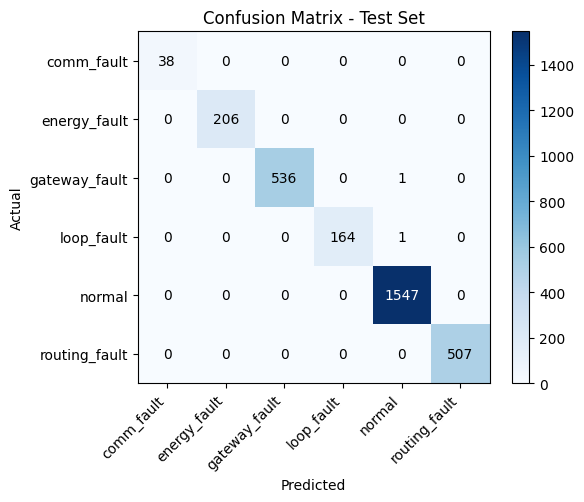


=== REPLAY / REAL-TIME SIMULATION TEST ===
Accuracy: 0.9966666666666667

Classification Report (Replay):

               precision    recall  f1-score   support

   comm_fault       1.00      1.00      1.00         3
 energy_fault       1.00      1.00      1.00        27
gateway_fault       1.00      0.98      0.99        50
   loop_fault       1.00      1.00      1.00        15
       normal       0.99      1.00      1.00       161
routing_fault       1.00      1.00      1.00        44

     accuracy                           1.00       300
    macro avg       1.00      1.00      1.00       300
 weighted avg       1.00      1.00      1.00       300



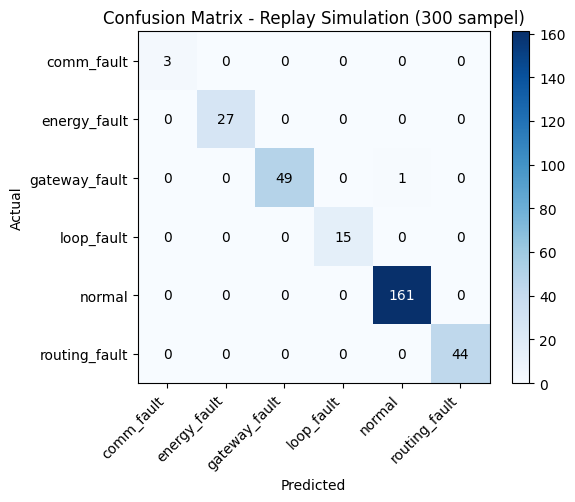

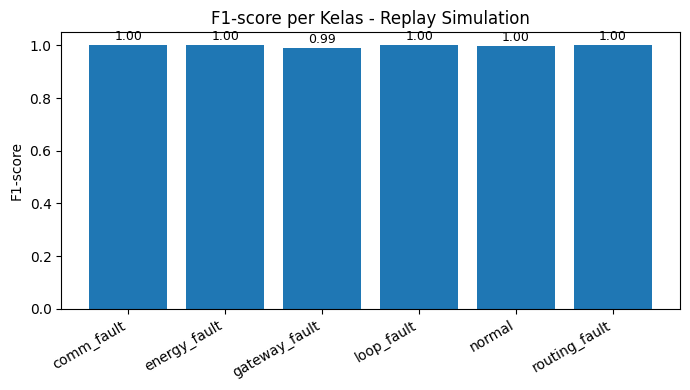


=== SCENARIO-BASED SIMULATION (10 sampel per kelas) ===
  kelas_sebenarnya prediksi_model  benar?
0       comm_fault     comm_fault    True
1       comm_fault     comm_fault    True
2       comm_fault     comm_fault    True
3       comm_fault     comm_fault    True
4       comm_fault     comm_fault    True

Rekap akurasi per kelas (Scenario-Based):
kelas_sebenarnya
comm_fault       1.0
energy_fault     1.0
gateway_fault    1.0
loop_fault       1.0
normal           1.0
routing_fault    1.0
Name: benar?, dtype: float64


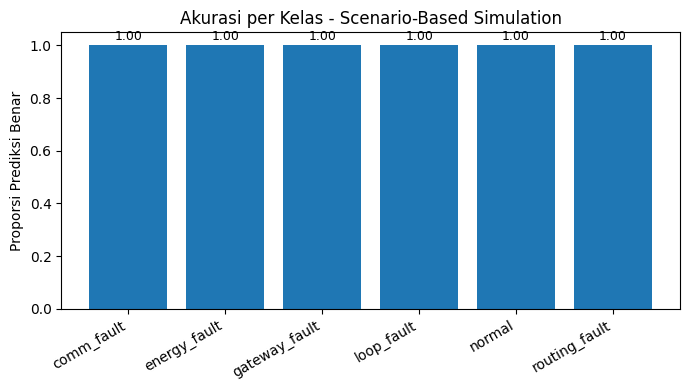


=== BASE ROW UNTUK STRESS TEST (NORMAL) ===
energy_level         41.717874
energy_drop_rate      2.612064
latency_ms          236.468754
end_to_end_delay    516.633909
packet_loss          26.983124
throughput_kbps     127.826111
Name: 4865, dtype: float64
Prediksi awal: normal

=== HASIL STRESS TEST ===
    loss_factor  delay_factor  packet_loss  end_to_end_delay       prediksi  \
0             1           1.0    26.983124        516.633909         normal   
1             1           1.5    26.983124        774.950864         normal   
2             1           2.0    26.983124       1033.267819  routing_fault   
3             1           3.0    26.983124       1549.901728  routing_fault   
4             2           1.0    53.966248        516.633909         normal   
5             2           1.5    53.966248        774.950864         normal   
6             2           2.0    53.966248       1033.267819         normal   
7             2           3.0    53.966248       1549.901728 

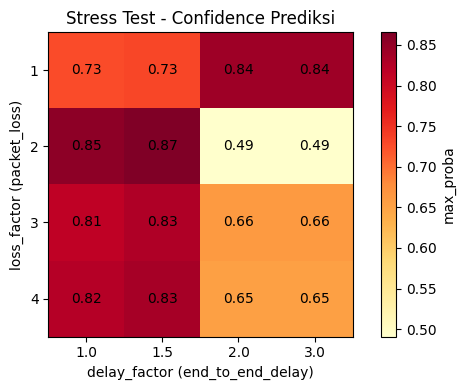


=== CEK OVERFITTING ===
Train Accuracy: 0.9999166666666667
Test  Accuracy: 0.9993333333333333

F1-macro CV scores: [0.99954063 0.99898512 0.99954063 0.99923341 0.99943956]
Mean F1-macro: 0.9993478729324353
Std  F1-macro: 0.00021326657200155063


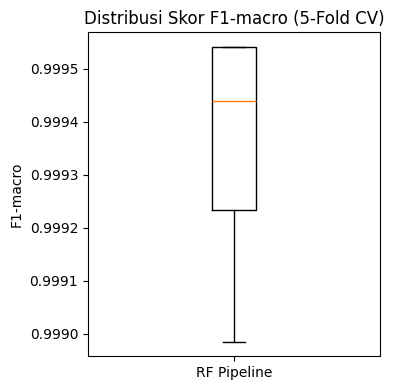

In [ ]:
# ===============================================
# FINALISASI MODEL + TESTING & VISUALISASI
# ===============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# ------------------------------------------------
# 1. LOAD DATA & SPLIT
# ------------------------------------------------
df = pd.read_excel("dataset_labeled_wsn.xlsx")

X = df.drop(columns=["label"])
y = df["label"]

print("Distribusi label total:", Counter(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Distribusi label TRAIN:", Counter(y_train))
print("Distribusi label TEST :", Counter(y_test))

label_order = sorted(y.unique())
# ============================================================
# Hitung Imbalance Ratio (IR) sesuai teori di proposal
# IR = jumlah_kelas_terbanyak / jumlah_kelas_tersedikit
# ============================================================
label_counts = Counter(y)
max_count = max(label_counts.values())
min_count = min(label_counts.values())
IR_total = max_count / min_count

print(f"\nImbalance Ratio TOTAL (IR): {IR_total:.2f}")

# IR untuk train set (opsional tapi bagus untuk laporan)
train_counts = Counter(y_train)
max_train = max(train_counts.values())
min_train = min(train_counts.values())
IR_train = max_train / min_train

print(f"Imbalance Ratio TRAIN (IR_train): {IR_train:.2f}")

# IR test biasanya sama karena stratified split
test_counts = Counter(y_test)
max_test = max(test_counts.values())
min_test = min(test_counts.values())
IR_test = max_test / min_test

print(f"Imbalance Ratio TEST (IR_test): {IR_test:.2f}")


# ------------------------------------------------
# 2. PIPELINE FINAL: SCALER + SMOTE + RANDOM FOREST
#    PARAMETER RF SESUAI TUNING MU:
#    n_estimators=279, max_depth=5, min_samples_leaf=2, min_samples_split=2, max_features='sqrt'
# ------------------------------------------------

rf_pipeline = ImbPipeline(steps=[
    ("scaler", StandardScaler()),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("rf", RandomForestClassifier(
        n_estimators=279,
        max_depth=5,
        min_samples_leaf=2,
        min_samples_split=2,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    ))
])

# Train model
rf_pipeline.fit(X_train, y_train)

# ------------------------------------------------
# 3. EVALUASI UTAMA DI TEST SET
# ------------------------------------------------
y_test_pred = rf_pipeline.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)
report_test = classification_report(y_test, y_test_pred, output_dict=True)

print("\n=== EVALUASI TEST SET ===")
print("Accuracy:", acc_test)
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred, labels=label_order)

# Visual: Confusion Matrix Test
plt.figure(figsize=(6, 5))
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Test Set")
plt.colorbar()
tick_marks = np.arange(len(label_order))
plt.xticks(tick_marks, label_order, rotation=45, ha="right")
plt.yticks(tick_marks, label_order)

thresh = cm_test.max() / 2.
for i in range(cm_test.shape[0]):
    for j in range(cm_test.shape[1]):
        plt.text(j, i, format(cm_test[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_test[i, j] > thresh else "black")

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# ------------------------------------------------
# 4. REPLAY / REAL-TIME SIMULATION TEST
# ------------------------------------------------
# Ambil subset test (300 sampel)
simulasi_X = X_test.sample(300, random_state=42)
simulasi_y = y_test.loc[simulasi_X.index]

simulasi_pred = rf_pipeline.predict(simulasi_X)

print("\n=== REPLAY / REAL-TIME SIMULATION TEST ===")
print("Accuracy:", accuracy_score(simulasi_y, simulasi_pred))
print("\nClassification Report (Replay):\n")
print(classification_report(simulasi_y, simulasi_pred))

cm_replay = confusion_matrix(simulasi_y, simulasi_pred, labels=label_order)

# Visual: Confusion Matrix Replay
plt.figure(figsize=(6, 5))
plt.imshow(cm_replay, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Replay Simulation (300 sampel)")
plt.colorbar()
tick_marks = np.arange(len(label_order))
plt.xticks(tick_marks, label_order, rotation=45, ha="right")
plt.yticks(tick_marks, label_order)

thresh = cm_replay.max() / 2.
for i in range(cm_replay.shape[0]):
    for j in range(cm_replay.shape[1]):
        plt.text(j, i, format(cm_replay[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm_replay[i, j] > thresh else "black")

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout()
plt.show()

# Visual: F1-score per kelas (Replay)
report_replay = classification_report(simulasi_y, simulasi_pred, output_dict=True)

class_names = []
f1_scores = []
for cls in label_order:
    class_names.append(cls)
    f1_scores.append(report_replay[cls]["f1-score"])

plt.figure(figsize=(7, 4))
bars = plt.bar(class_names, f1_scores)
plt.ylim(0, 1.05)
plt.title("F1-score per Kelas - Replay Simulation")
plt.ylabel("F1-score")
plt.xticks(rotation=30, ha="right")

for bar, score in zip(bars, f1_scores):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.01,
             f"{score:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# ------------------------------------------------
# 5. SCENARIO-BASED SIMULATION (10 sampel per kelas)
# ------------------------------------------------
samples_per_class = 10
rows = []

for label in label_order:
    # pastikan kelas ini punya cukup sampel
    idx_candidates = y_test[y_test == label].index
    n_sample = min(samples_per_class, len(idx_candidates))
    idx = np.random.choice(idx_candidates, size=n_sample, replace=False)

    X_subset = X_test.loc[idx]
    y_subset = y_test.loc[idx]
    y_pred_subset = rf_pipeline.predict(X_subset)

    for true_l, pred_l in zip(y_subset, y_pred_subset):
        rows.append({
            "kelas_sebenarnya": true_l,
            "prediksi_model": pred_l,
            "benar?": (true_l == pred_l)
        })

scenario_df = pd.DataFrame(rows)
print("\n=== SCENARIO-BASED SIMULATION (10 sampel per kelas) ===")
print(scenario_df.head())

rekap_skenario = scenario_df.groupby("kelas_sebenarnya")["benar?"].mean()
print("\nRekap akurasi per kelas (Scenario-Based):")
print(rekap_skenario)

# Visual: Akurasi per kelas
plt.figure(figsize=(7, 4))
bars = plt.bar(rekap_skenario.index, rekap_skenario.values)
plt.ylim(0, 1.05)
plt.title("Akurasi per Kelas - Scenario-Based Simulation")
plt.ylabel("Proporsi Prediksi Benar")
plt.xticks(rotation=30, ha="right")

for bar, val in zip(bars, rekap_skenario.values):
    plt.text(bar.get_x() + bar.get_width()/2,
             val + 0.01,
             f"{val:.2f}",
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# ------------------------------------------------
# 6. STRESS TEST (1 sampel normal, variasi packet_loss & delay)
# ------------------------------------------------
# Ambil satu sampel normal
normal_idx = y_test[y_test == "normal"].sample(1, random_state=42).index[0]
base_row = X_test.loc[normal_idx].copy()

print("\n=== BASE ROW UNTUK STRESS TEST (NORMAL) ===")
print(base_row)
print("Prediksi awal:", rf_pipeline.predict(base_row.to_frame().T)[0])

loss_factors = [1, 2, 3, 4]
delay_factors = [1.0, 1.5, 2.0, 3.0]

results = []

for lf in loss_factors:
    for dfac in delay_factors:
        test_row = base_row.copy()
        test_row["packet_loss"] = base_row["packet_loss"] * lf
        test_row["end_to_end_delay"] = base_row["end_to_end_delay"] * dfac

        pred = rf_pipeline.predict(test_row.to_frame().T)[0]
        proba = rf_pipeline.predict_proba(test_row.to_frame().T)[0]
        max_proba = np.max(proba)

        results.append({
            "loss_factor": lf,
            "delay_factor": dfac,
            "packet_loss": test_row["packet_loss"],
            "end_to_end_delay": test_row["end_to_end_delay"],
            "prediksi": pred,
            "max_proba": max_proba
        })

stress_df = pd.DataFrame(results)
print("\n=== HASIL STRESS TEST ===")
print(stress_df)

# Visual: Heatmap confidence (max_proba) vs loss_factor & delay_factor
pivot_conf = stress_df.pivot(index="loss_factor",
                             columns="delay_factor",
                             values="max_proba")

plt.figure(figsize=(6, 4))
plt.imshow(pivot_conf, interpolation='nearest', cmap=plt.cm.YlOrRd)
plt.title("Stress Test - Confidence Prediksi")
plt.colorbar(label="max_proba")

xticks = np.arange(len(pivot_conf.columns))
yticks = np.arange(len(pivot_conf.index))
plt.xticks(xticks, pivot_conf.columns)
plt.yticks(yticks, pivot_conf.index)
plt.xlabel("delay_factor (end_to_end_delay)")
plt.ylabel("loss_factor (packet_loss)")

for i, lf in enumerate(pivot_conf.index):
    for j, dfac in enumerate(pivot_conf.columns):
        val = pivot_conf.loc[lf, dfac]
        plt.text(j, i, f"{val:.2f}",
                 ha="center", va="center",
                 color="black")

plt.tight_layout()
plt.show()

# ------------------------------------------------
# 7. CEK OVERFITTING: TRAIN vs TEST + CV
# ------------------------------------------------
# Akurasi TRAIN
y_train_pred = rf_pipeline.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

# Akurasi TEST
test_acc = accuracy_score(y_test, y_test_pred)

print("\n=== CEK OVERFITTING ===")
print("Train Accuracy:", train_acc)
print("Test  Accuracy:", test_acc)

# Cross-Validation F1-macro
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_cv_scores = cross_val_score(
    rf_pipeline,
    X, y,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1
)

print("\nF1-macro CV scores:", f1_cv_scores)
print("Mean F1-macro:", f1_cv_scores.mean())
print("Std  F1-macro:", f1_cv_scores.std())

# Visual: Boxplot CV scores
plt.figure(figsize=(4, 4))
plt.boxplot(f1_cv_scores, vert=True)
plt.ylabel("F1-macro")
plt.title("Distribusi Skor F1-macro (5-Fold CV)")
plt.xticks([1], ["RF Pipeline"])
plt.tight_layout()
plt.show()
